# Context


Filterimg high frequencies then applying tracking.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import pickle
import os
source_folder = os.path.join(Path(os.getcwd()).parent.parent, "source_data")

### Import our custom utility methods

In [6]:
import sys
%reload_ext autoreload
%autoreload 2
sys.path.append('../..')

from utils.visualization_tools import *
import utils.visualization_tools
from utils.data_transformations import *
import utils.data_transformations
from utils.diverse import *
import utils.diverse
from utils.cluster_tracking import FastDensityClustering

In [7]:
frames = skimage.io.imread(os.path.join(source_folder,"runstart16_X1.tif"))
frames = frames[:1000,:,:]

In [69]:
mean = np.mean(frames,axis=0)#pixelwise mean
difference = normalize(framewise_difference(frames, mean, bigdata=False))
smooth = normalize(gaussian_filter(substract_pixel_min(difference), 1))
filtered = remove_frequency_from_pixel_vectors(smooth,90,100)
filtered_in_space = normalize(filtered-smooth)
roi = clipped_adaptive(filtered_in_space[:,120:180,80:140])[:,:-8,:-8]

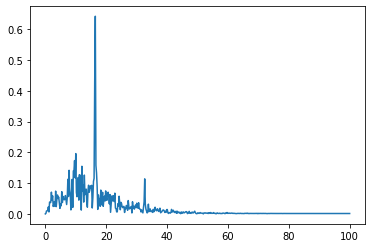

In [70]:
frequencies = gaussian_filter(np.mean(smooth, axis = (1,2))-gaussian_filter(np.mean(smooth, axis = (1,2)),3),1)
plt.plot(*fourier(frequencies))

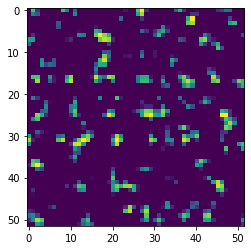

In [71]:
plt.imshow(roi[0], vmin =0, vmax=1)

In [72]:
res = FastDensityClustering.density_clustering(roi[8],  gravity_size=2, gravity_type="disk")
res1 = FastDensityClustering.density_clustering(roi[9],  gravity_size=2, gravity_type="disk")

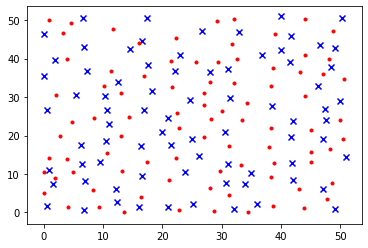

In [73]:
fig, ax = plt.subplots(1)
ax.scatter(res[0],res[1],c="b", marker="x")
ax.scatter(res1[0],res1[1],c="r",marker=".")

# Cluster tracking

In [74]:
labeled_tensor = FastDensityClustering.cluster_tracking(roi, mode="closest_center")

...................................................................................................

In [75]:
examples = labeled_tensor

In [76]:
examples[examples>100] = -1

In [77]:
%%capture
from matplotlib import cm

vals = np.linspace(0,1,512)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
cmap.colors[0] = [0,0,0,0]
fig, ax = plt.subplots(1,2, figsize=(10,10))
im = ax[0].imshow(labeled_tensor[1], cmap = cmap, vmin=0,vmax=int(np.max(labeled_tensor)))
im1 = ax[1].imshow(roi[1],vmin=0,vmax=1)
ani = matplotlib.animation.FuncAnimation(fig, lambda i: [im.set_array(labeled_tensor[i]),im1.set_array(roi[i])], 
                                         frames=len(labeled_tensor)-1).to_jshtml()

In [78]:
HTML(ani)

In [79]:
mapp, preliminary_label_tensor, coords = FastDensityClustering.mappings(roi,mode="closest_center", frames=1000)

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [80]:
import copy

In [81]:
labeled_tensor = FastDensityClustering.cluster_tracking(roi, mode="closest_center", frames = 1000)

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [82]:
traces = []

for i in range(998):
    label_selected = roi[:999,:,:].copy()
    label_selected[labeled_tensor!=i] = 0
    trace = np.array([FastDensityClustering.center_of_mass(label_selected[i]) for i in range(len(label_selected))]).T
    traces.append(trace)

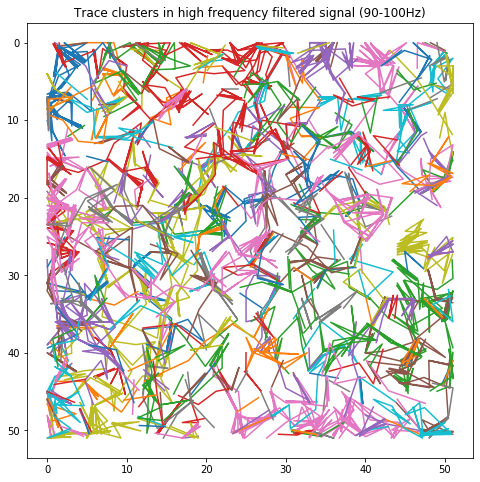

In [86]:
trace = np.array([FastDensityClustering.center_of_mass(label_selected[i]) for i in range(len(label_selected))]).T

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_title("Trace clusters in high frequency filtered signal (90-100Hz)")
ax.invert_yaxis()
for trace in traces:
    where = np.where(~np.logical_and(trace[0] == 0.0, trace[1] == 0.0))
    trace = trace.T[where].T
    ax.plot(*trace)